## Post Training Quantization for MNIST using Pytorch (16 bits)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import pandas as pd
from tabulate import tabulate

### Define the model

In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()


### Process dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# División del conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### Train the model

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.4241
Epoch [2/10], Loss: 0.1929
Epoch [3/10], Loss: 0.1376
Epoch [4/10], Loss: 0.1066
Epoch [5/10], Loss: 0.0871
Epoch [6/10], Loss: 0.0731
Epoch [7/10], Loss: 0.0612
Epoch [8/10], Loss: 0.0544
Epoch [9/10], Loss: 0.0453
Epoch [10/10], Loss: 0.0404


### Validation 

In [5]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

torch.save(model.state_dict() , 'models/original_model.pth')
acc_original_model=100 * correct / total

Validation Accuracy: 96.94%


In [6]:
module = model.fc1
print(list(module.named_parameters()))

[('weight', Parameter containing:
tensor([[ 0.0064,  0.0275, -0.0277,  ...,  0.0224,  0.0214, -0.0279],
        [ 0.0193,  0.0252,  0.0351,  ...,  0.0021, -0.0150, -0.0167],
        [ 0.0076,  0.0074,  0.0060,  ..., -0.0044,  0.0277, -0.0004],
        ...,
        [ 0.0144, -0.0066,  0.0279,  ...,  0.0017,  0.0138, -0.0227],
        [-0.0182, -0.0234, -0.0002,  ...,  0.0256,  0.0211, -0.0244],
        [-0.0049, -0.0243,  0.0193,  ..., -0.0107, -0.0159,  0.0128]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.1539,  0.0057,  0.0502,  0.0179,  0.1066, -0.0363,  0.0636,  0.1859,
         0.1188, -0.0593,  0.0162,  0.0710,  0.1200,  0.0106, -0.0248, -0.0746,
         0.1570, -0.0347, -0.0090,  0.0162, -0.0425, -0.0726, -0.0646,  0.0323,
        -0.0791,  0.0810,  0.0178, -0.0380,  0.0921,  0.0415,  0.1159, -0.0435,
        -0.0391, -0.0551,  0.0856,  0.1145,  0.0401,  0.1797,  0.0584,  0.1583,
         0.1173,  0.0076,  0.0388,  0.2977, -0.0239,  0.0520,  0.0093,  

In [7]:
# Supongamos que tienes el modelo en la variable 'model'
weights = []

for param in model.parameters():
    if param.requires_grad:
        weights.extend(param.detach().cpu().numpy().flatten())


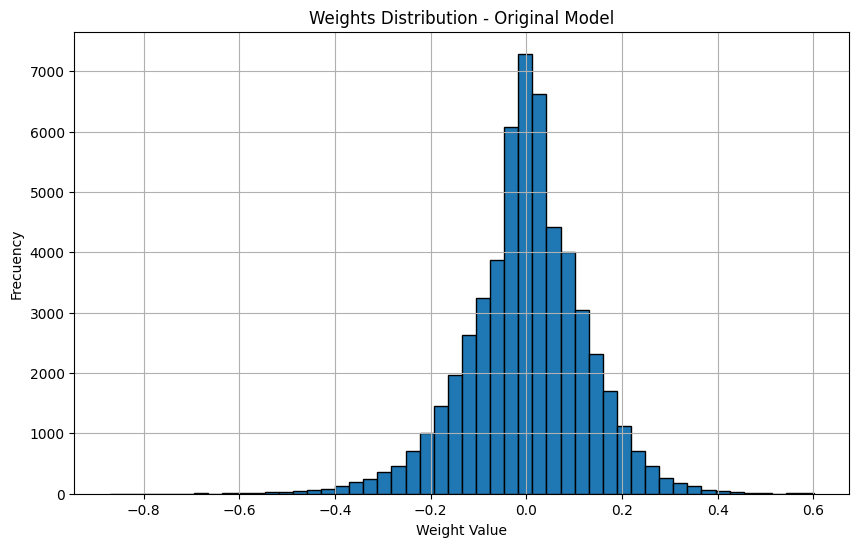

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.hist(weights, bins=50, edgecolor='black')
plt.title('Weights Distribution - Original Model')
plt.xlabel('Weight Value')
plt.ylabel('Frecuency')
plt.grid(True)
plt.show()


### Quantization

In [9]:
model_int16 = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.float16
)
torch.save(model_int16.state_dict(), 'models/model_quant_float16.pth')


In [10]:
# Imprimir los pesos de una capa para verificar la cuantización
for name, param in model_int16.named_parameters():
    print(f'{name}: min={param.min()}, max={param.max()}')

from torch.ao.quantization.observer import get_observer_state_dict
# Obtener el diccionario de observadores que monitorean la cuantización en el modelo
observer_dict = get_observer_state_dict(model_int16)

# Imprimir estadísticas de los observadores para verificar el rango de cuantización
for name, observer in observer_dict.items():
    print(f'{name}: scale={observer.min_val}, zero_point={observer.zero_point}')



In [11]:
# Crear una entrada de prueba
input_fp32 = torch.randn(1, 1, 28, 28)

# Ejecutar la inferencia en el modelo cuantizado
model_int16.eval()
with torch.no_grad():
    output_int8 = model_int16(input_fp32)

print("Output del modelo cuantizado:")
print(output_int8)


Output del modelo cuantizado:
tensor([[  2.0221,  -5.8476,  -5.7010, -10.6524, -11.9261,   9.4886,   7.1574,
         -16.3852,  -6.9302, -16.4924]])


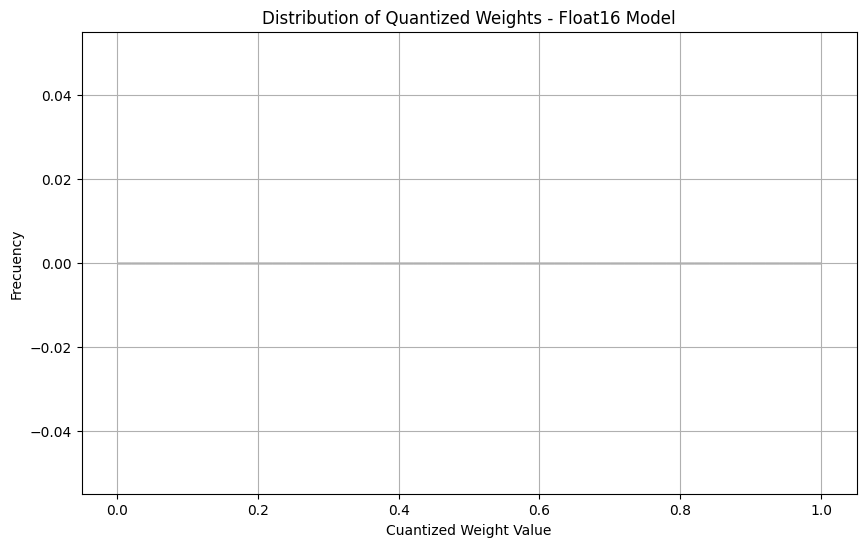

In [12]:
import torch
import matplotlib.pyplot as plt

'''def get_quantized_weights(model):
    weights = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.quantized.Linear) or isinstance(module, torch.nn.quantized.Conv2d):
            # Para capas cuantizadas, obtenemos los pesos directamente
            weight = module.weight()
            weights.extend(weight.int_repr().flatten().cpu().numpy())  # Convertimos a numpy
    return weights

# Asumiendo que 'quantized_model' es tu modelo cuantizado
quantized_weights = get_quantized_weights(model_int16)'''

# Supongamos que tienes el modelo en la variable 'model'
quantized_weights = []

for param in model.parameters():
    if param.requires_grad:
        weights.extend(param.detach().cpu().numpy().flatten())


# Graficar la distribución de los pesos cuantizados
plt.figure(figsize=(10, 6))
plt.hist(quantized_weights, bins=50, edgecolor='black')
plt.title('Distribution of Quantized Weights - Float16 Model')
plt.xlabel('Cuantized Weight Value')
plt.ylabel('Frecuency')
plt.grid(True)
plt.show()


### Evaluation

In [13]:
model_int16.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_int16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy of the quantized model: {100 * correct / total:.2f}%')
acc_postTraining_16bit=100 * correct / total

Test accuracy of the quantized model: 97.09%


### Size of the models

In [14]:
float_model_size = os.path.getsize('models/original_model.pth') / float(2**20)
quant_model_size = os.path.getsize('models/model_quant_float16.pth') / float(2**20)

print("Float model in Mb:", float_model_size)
print("Quantized model in Mb:", quant_model_size)


Float model in Mb: 0.2125377655029297
Quantized model in Mb: 0.2144031524658203


## Post Training Quantization for MNIST using Pytorch (8 bits)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os


### Define the model

In [16]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()


### Process dataset

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# División del conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### Train the model

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.4384
Epoch [2/10], Loss: 0.2003
Epoch [3/10], Loss: 0.1450
Epoch [4/10], Loss: 0.1145
Epoch [5/10], Loss: 0.0944
Epoch [6/10], Loss: 0.0791
Epoch [7/10], Loss: 0.0674
Epoch [8/10], Loss: 0.0564
Epoch [9/10], Loss: 0.0497
Epoch [10/10], Loss: 0.0425


### Validation 

In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

torch.save(model.state_dict(), 'models/original_model.pth')
acc_original_model=100 * correct / total

Validation Accuracy: 97.19%


In [20]:
module = model.fc1
print(list(module.named_parameters()))

[('weight', Parameter containing:
tensor([[-0.0228,  0.0048, -0.0232,  ..., -0.0091,  0.0167, -0.0186],
        [-0.0232, -0.0357,  0.0055,  ...,  0.0111,  0.0151,  0.0301],
        [-0.0031,  0.0243, -0.0253,  ...,  0.0290,  0.0231,  0.0193],
        ...,
        [ 0.0192,  0.0183,  0.0258,  ..., -0.0128, -0.0293,  0.0273],
        [ 0.0156,  0.0250,  0.0207,  ...,  0.0288,  0.0314,  0.0074],
        [ 0.0266, -0.0047, -0.0086,  ...,  0.0145,  0.0020,  0.0093]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.0773,  0.0054, -0.0276, -0.0597,  0.0758, -0.1580, -0.0019, -0.1660,
         0.2798,  0.1432,  0.0956,  0.0390,  0.0944, -0.0805, -0.1821,  0.2798,
         0.2262, -0.0174,  0.2382,  0.0825, -0.1012,  0.0404, -0.0943,  0.2251,
         0.0649, -0.0110,  0.2071,  0.0019,  0.0486,  0.1890,  0.1310,  0.0135,
        -0.0892, -0.0398,  0.0702,  0.1611,  0.0825,  0.1409,  0.0317, -0.0345,
         0.1418,  0.2925,  0.1108, -0.0845,  0.1451,  0.1512,  0.1394, -

In [21]:
# Supongamos que tienes el modelo en la variable 'model'
weights = []

for param in model.parameters():
    if param.requires_grad:
        weights.extend(param.detach().cpu().numpy().flatten())


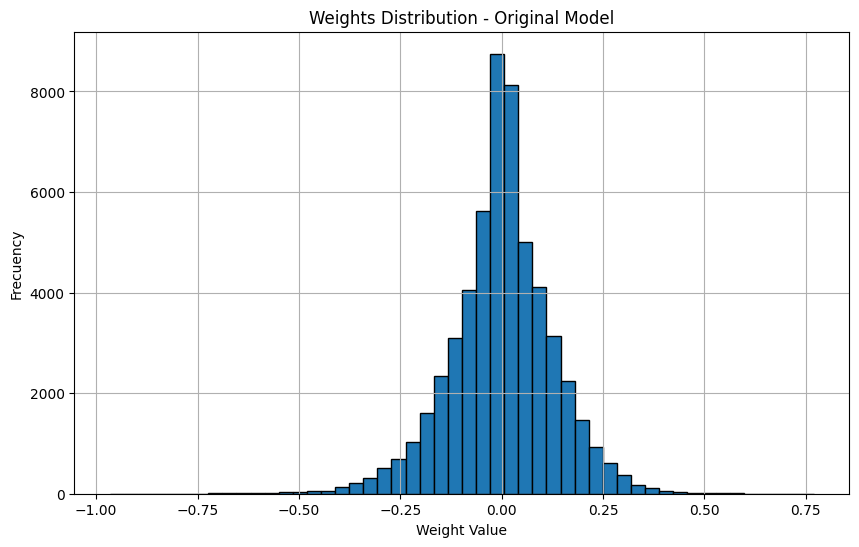

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.hist(weights, bins=50, edgecolor='black')
plt.title('Weights Distribution - Original Model')
plt.xlabel('Weight Value')
plt.ylabel('Frecuency')
plt.grid(True)
plt.show()


### Quantization

In [23]:
model_int8 = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)
torch.save(model_int8.state_dict(), 'models/model_quant_int8.pth')


In [24]:
# Imprimir los pesos de una capa para verificar la cuantización
for name, param in model_int8.named_parameters():
    print(f'{name}: min={param.min()}, max={param.max()}')

from torch.ao.quantization.observer import get_observer_state_dict
# Obtener el diccionario de observadores que monitorean la cuantización en el modelo
observer_dict = get_observer_state_dict(model_int8)

# Imprimir estadísticas de los observadores para verificar el rango de cuantización
for name, observer in observer_dict.items():
    print(f'{name}: scale={observer.min_val}, zero_point={observer.zero_point}')



In [25]:
# Crear una entrada de prueba
input_fp32 = torch.randn(1, 1, 28, 28)

# Ejecutar la inferencia en el modelo cuantizado
model_int8.eval()
with torch.no_grad():
    output_int8 = model_int8(input_fp32)

print("Output del modelo cuantizado:")
print(output_int8)


Output del modelo cuantizado:
tensor([[-22.7029,  -8.8906,  -9.1724,   3.7381,   1.9414,  -1.1111, -31.1214,
           0.5972,  -4.1645,  10.2646]])


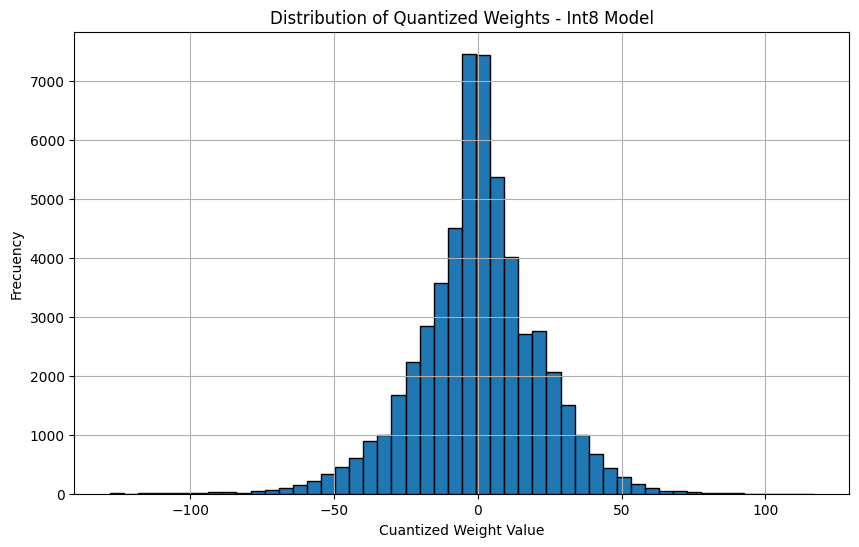

In [26]:
import torch
import matplotlib.pyplot as plt

def get_quantized_weights(model):
    weights = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.quantized.Linear) or isinstance(module, torch.nn.quantized.Conv2d):
            # Para capas cuantizadas, obtenemos los pesos directamente
            weight = module.weight()
            weights.extend(weight.int_repr().flatten().cpu().numpy())  # Convertimos a numpy
    return weights

# Asumiendo que 'quantized_model' es tu modelo cuantizado
quantized_weights = get_quantized_weights(model_int8)

# Graficar la distribución de los pesos cuantizados
plt.figure(figsize=(10, 6))
plt.hist(quantized_weights, bins=50, edgecolor='black')
plt.title('Distribution of Quantized Weights - Int8 Model')
plt.xlabel('Cuantized Weight Value')
plt.ylabel('Frecuency')
plt.grid(True)
plt.show()


### Evaluation

In [27]:
model_int8.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_int8(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy of the quantized model: {100 * correct / total:.2f}%')
acc_postTraining_8bit=100 * correct / total

Test accuracy of the quantized model: 97.12%


### Size of the models

In [28]:
float_model_size = os.path.getsize('models/original_model.pth') / float(2**20)
quant_model_size = os.path.getsize('models/model_quant_int8.pth') / float(2**20)

print("Float model in Mb:", float_model_size)
print("Quantized model in Mb:", quant_model_size)


Float model in Mb: 0.2125377655029297
Quantized model in Mb: 0.05737495422363281


## Post Training Quantization for MNIST (5 bits)

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os


In [30]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()


In [31]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.4088
Epoch [2/10], Loss: 0.1839
Epoch [3/10], Loss: 0.1319
Epoch [4/10], Loss: 0.1047
Epoch [5/10], Loss: 0.0862
Epoch [6/10], Loss: 0.0714
Epoch [7/10], Loss: 0.0614
Epoch [8/10], Loss: 0.0524
Epoch [9/10], Loss: 0.0441
Epoch [10/10], Loss: 0.0380


In [33]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

torch.save(model.state_dict(), 'models/original_model.pth')


Validation Accuracy: 97.33%


### Quantize weights

In [34]:
def quantize_weights_5bits(tensor):
    # Definir el rango máximo para 5 bits (32 valores)
    min_val, max_val = tensor.min(), tensor.max()
    scale = (max_val - min_val) / 31.0  # 2^5 - 1 = 31

    # Cuantizar
    quantized_tensor = torch.round((tensor - min_val) / scale) * scale + min_val
    return quantized_tensor

def quantize_model_5bits(model):
    quantized_model = SimpleNN()  # Crear una nueva instancia del modelo

    for name, param in model.named_parameters():
        if 'weight' in name:  # Cuantizar solo los pesos
            quantized_param = quantize_weights_5bits(param.data)
            layer_name, param_type = name.split('.')
            layer = getattr(quantized_model, layer_name)

            # Asegúrate de que el atributo es un tensor y no una función
            if isinstance(getattr(layer, param_type), torch.Tensor):
                setattr(layer, param_type, nn.Parameter(quantized_param))
            else:
                raise ValueError(f"Expected {param_type} to be a tensor, but got {type(getattr(layer, param_type))} instead.")
        else:
            # Copiar otros parámetros directamente (como los sesgos)
            layer_name, param_type = name.split('.')
            layer = getattr(quantized_model, layer_name)
            setattr(layer, param_type, nn.Parameter(param.data))

    return quantized_model


### Evaluate model

In [35]:
quantized_model_5bits = quantize_model_5bits(model)

# Guarda el modelo cuantizado
torch.save(quantized_model_5bits.state_dict(), 'models/model_quant_5bits.pth')


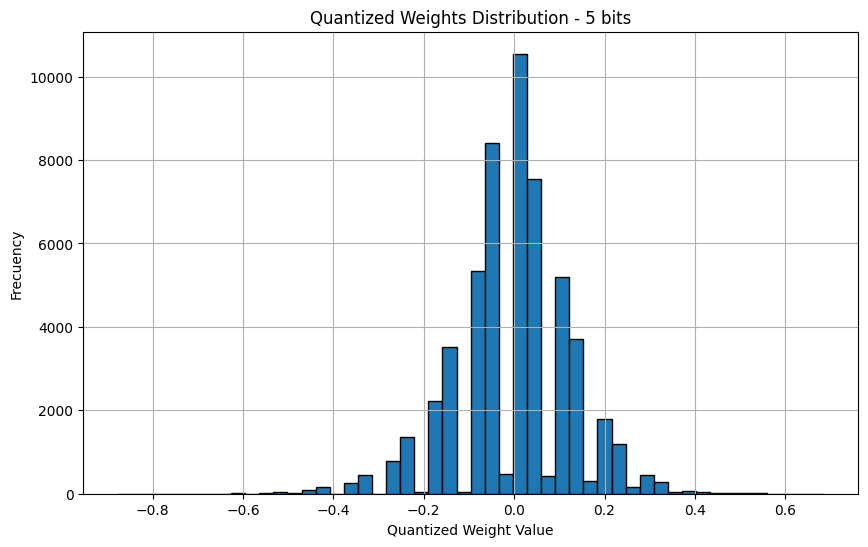

In [36]:
import torch
import matplotlib.pyplot as plt

# Supongamos que tienes el modelo en la variable 'model'
quantized_weights = []

for param in quantized_model_5bits.parameters():
    if param.requires_grad:
        quantized_weights.extend(param.detach().cpu().numpy().flatten())

# Graficar la distribución de los pesos cuantizados
plt.figure(figsize=(10, 6))
plt.hist(quantized_weights, bins=50, edgecolor='black')
plt.title('Quantized Weights Distribution - 5 bits')
plt.xlabel('Quantized Weight Value')
plt.ylabel('Frecuency')
plt.grid(True)
plt.show()


In [37]:

# Evalúa el modelo cuantizado
quantized_model_5bits.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = quantized_model_5bits(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy of the quantized 5-bit model: {100 * correct / total:.2f}%')
acc_postTraining_5bit=100 * correct / total

Test accuracy of the quantized 5-bit model: 97.29%


In [38]:
float_model_size = os.path.getsize('models/original_model.pth') / float(2**20)
quant_model_size_5bits = os.path.getsize('models/model_quant_5bits.pth') / float(2**20)

print("Float model in Mb:", float_model_size)
print("Quantized 5-bit model in Mb:", quant_model_size_5bits)


Float model in Mb: 0.2125377655029297
Quantized 5-bit model in Mb: 0.21256637573242188


In [39]:
def save_quantized_model(quantized_model, path):
    quantized_weights = {}
    for name, param in quantized_model.named_parameters():
        # Convertimos a un tipo de dato que ocupe menos espacio (por ejemplo, int8)
        quantized_weights[name] = param.data.numpy().astype(np.int8)
    np.savez_compressed(path, **quantized_weights)
def load_quantized_model(quantized_model, path):
    data = np.load(path)
    for name, param in quantized_model.named_parameters():
        # Restauramos los pesos con la cuantización aplicada
        param.data = torch.tensor(data[name]).float()
    return quantized_model

save_quantized_model(quantized_model_5bits, 'models/model_quant_5bits_compressed.npz')

In [40]:
loaded_model = SimpleNN()
loaded_model = load_quantized_model(loaded_model, 'models/model_quant_5bits_compressed.npz')

In [41]:
# Paso 3: Comparar el tamaño de los archivos
original_model_size = os.path.getsize('models/original_model.pth')
quantized_model_size = os.path.getsize('models/model_quant_5bits_compressed.npz')

print(f"Tamaño del modelo original: {original_model_size / 1024:.2f} KB")
print(f"Tamaño del modelo cuantizado: {quantized_model_size / 1024:.2f} KB")

Tamaño del modelo original: 217.64 KB
Tamaño del modelo cuantizado: 1.27 KB


# Grafics of Post Training Quantization

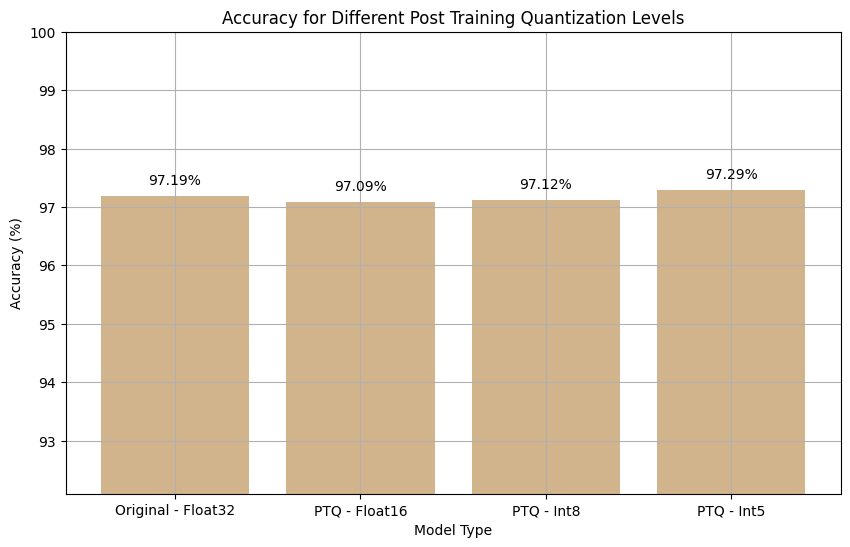

In [42]:
import matplotlib.pyplot as plt

# Etiquetas para cada modelo
labels = ['Original - Float32', 'PTQ - Float16', 'PTQ - Int8', 'PTQ - Int5']

# Valores de precisión
accuracies = [acc_original_model, acc_postTraining_16bit, acc_postTraining_8bit, acc_postTraining_5bit]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color='tan')

# Agregar títulos y etiquetas
plt.title('Accuracy for Different Post Training Quantization Levels')
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.2, f'{v:.2f}%', ha='center', fontsize=10)

# Mostrar la gráfica
plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.show()


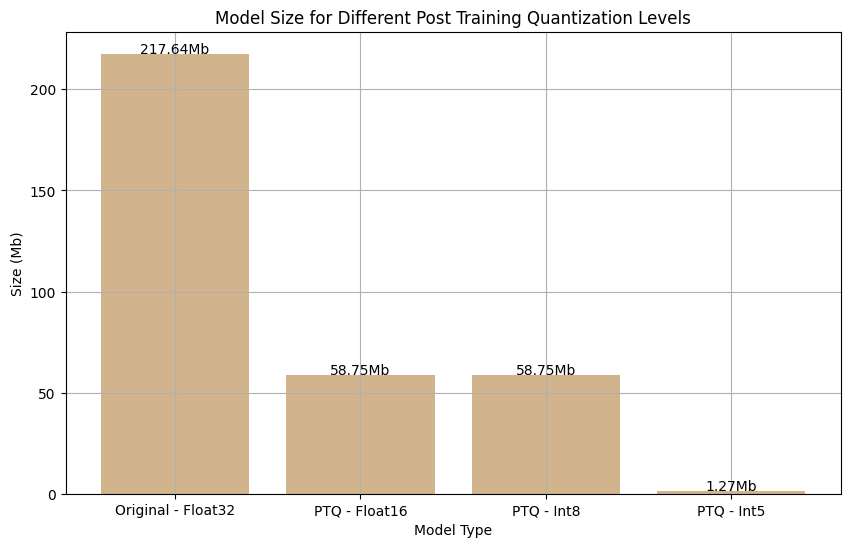

In [43]:
original_model_size = os.path.getsize('models/original_model.pth')/1024
quantized5bits_model_size = os.path.getsize('models/model_quant_5bits_compressed.npz')/1024
quantized8bits_model_size = os.path.getsize('models/model_quant_int8.pth') / 1024
quantized16bits_model_size = os.path.getsize('models/model_quant_int8.pth') / 1024


import matplotlib.pyplot as plt

# Etiquetas para cada modelo
labels = ['Original - Float32', 'PTQ - Float16', 'PTQ - Int8', 'PTQ - Int5']

# Valores de tamaño
sizes = [original_model_size, quantized16bits_model_size, quantized8bits_model_size, quantized5bits_model_size]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color='tan')

# Agregar títulos y etiquetas
plt.title('Model Size for Different Post Training Quantization Levels')
plt.xlabel('Model Type')
plt.ylabel('Size (Mb)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(sizes):
    plt.text(i, v + 0.2, f'{v:.2f}Mb', ha='center', fontsize=10)

# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.show()


## Quantization-aware training for MNIST (8-bit)

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization as quantization
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [45]:

# Paso 1: Preparar el Dataset MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


In [46]:

# Paso 2: Definir el modelo y configurarlo para QAT
class QATSimpleNN(nn.Module):
    def __init__(self):
        super(QATSimpleNN, self).__init__()
        # Se definen las capas convolucionales y de normalización para QAT
        self.quant = quantization.QuantStub()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dequant = quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dequant(x)
        return x


In [47]:

# Inicializamos el modelo y lo preparamos para QAT
model = QATSimpleNN()

# Fuse layers: para que el entrenamiento sea más eficiente
model.train()
model.qconfig = quantization.get_default_qat_qconfig('x86')
model = quantization.prepare_qat(model)


/home/martin/miniconda3/envs/dl/lib/python3.12/site-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [48]:

# Paso 3: Entrenar el modelo con QAT
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.1295
Epoch [2/10], Loss: 0.0419
Epoch [3/10], Loss: 0.1504
Epoch [4/10], Loss: 0.0041
Epoch [5/10], Loss: 0.0377
Epoch [6/10], Loss: 0.0159
Epoch [7/10], Loss: 0.0008
Epoch [8/10], Loss: 0.0044
Epoch [9/10], Loss: 0.0714
Epoch [10/10], Loss: 0.0204


In [49]:

# Paso 4: Convertir el modelo para inferencia cuantizada
model.eval()
model = quantization.convert(model)


In [50]:

# Paso 5: Evaluar el modelo cuantizado
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_qat_8bits = 100 * correct / total
print(f'Test accuracy of the quantized model: {acc_qat_8bits:.2f}%')


Test accuracy of the quantized model: 97.53%


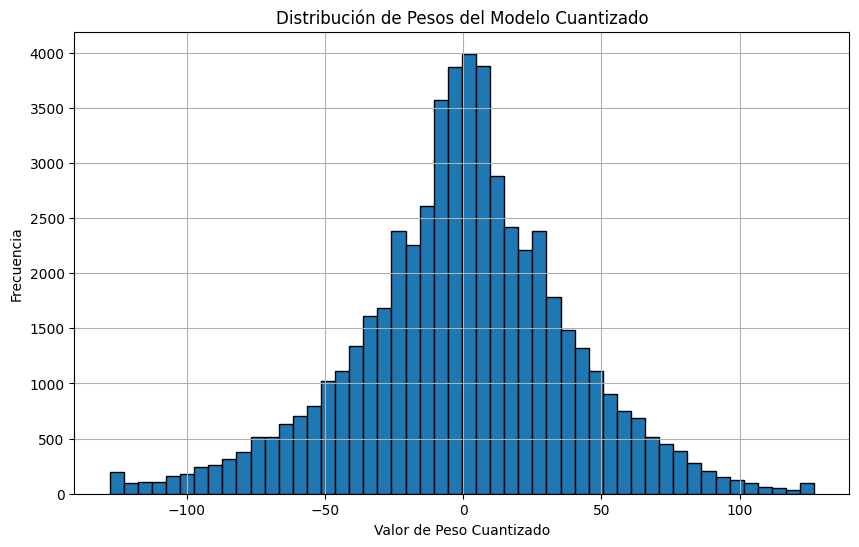

In [51]:
import torch
import matplotlib.pyplot as plt

def get_quantized_weights(model):
    weights = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.quantized.Linear) or isinstance(module, torch.nn.quantized.Conv2d):
            # Para capas cuantizadas, obtenemos los pesos directamente
            weight = module.weight()
            weights.extend(weight.int_repr().flatten().cpu().numpy())  # Convertimos a numpy
    return weights

# Asumiendo que 'quantized_model' es tu modelo cuantizado
quantized_weights = get_quantized_weights(model)

# Graficar la distribución de los pesos cuantizados
plt.figure(figsize=(10, 6))
plt.hist(quantized_weights, bins=50, edgecolor='black')
plt.title('Distribución de Pesos del Modelo Cuantizado')
plt.xlabel('Valor de Peso Cuantizado')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


In [52]:
# Verificar los tipos de operadores en el modelo cuantizado
for layer in model.modules():
    print(layer)


QATSimpleNN(
  (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (fc1): QuantizedLinear(in_features=784, out_features=64, scale=0.19034381210803986, zero_point=74, qscheme=torch.per_channel_affine)
  (fc2): QuantizedLinear(in_features=64, out_features=64, scale=0.19759759306907654, zero_point=66, qscheme=torch.per_channel_affine)
  (fc3): QuantizedLinear(in_features=64, out_features=10, scale=0.4404064118862152, zero_point=82, qscheme=torch.per_channel_affine)
  (dequant): DeQuantize()
)
Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
QuantizedLinear(in_features=784, out_features=64, scale=0.19034381210803986, zero_point=74, qscheme=torch.per_channel_affine)
(tensor([[ 0.0039, -0.0118,  0.0276,  ..., -0.0039,  0.0276, -0.0276],
        [-0.0146, -0.0110,  0.0110,  ..., -0.0110,  0.0000,  0.0110],
        [-0.0080,  0.0120,  0.0239,  ..., -0.0080, -0.0120,  0.0200],
        ...,
        [-0.0070,  0.0000,  0.0209,  ..., 

In [53]:

# Guardar el modelo cuantizado
torch.save(model, 'models/qat_mnist_model.pth')


In [54]:
import os
quantized8bits_model_size = os.path.getsize('models/qat_mnist_model.pth')
print(f"Tamaño del modelo cuantizado: {quantized8bits_model_size / 1024:.2f} KB")

Tamaño del modelo cuantizado: 63.43 KB


## Quantization Aware Training for MNIST (5 bits)

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.ao.quantization as quantization
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [56]:

# Paso 1: Preparar el Dataset MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


In [57]:

# Paso 2: Definir el Modelo con Soporte para QAT
class QATSimpleNN(nn.Module):
    def __init__(self):
        super(QATSimpleNN, self).__init__()
        self.quant = quantization.QuantStub()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dequant = quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = torch.relu(self.fc1(x.view(-1, 28*28)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dequant(x)
        return x


In [58]:

act = quantization.fake_quantize.FakeQuantize.with_args(observer=quantization.observer.MovingAverageMinMaxObserver, 
                        quant_min=0, quant_max=int(2 ** 5 - 1), dtype=torch.quint8, qscheme=torch.per_tensor_affine, reduce_range=False)
weights = quantization.fake_quantize.FakeQuantize.with_args(observer=quantization.observer.MovingAveragePerChannelMinMaxObserver, 
                        quant_min=int(-(2 ** 5) / 2), quant_max=int((2 ** 5) / 2 - 1), dtype=torch.qint8, qscheme=torch.per_channel_symmetric, reduce_range=False)

# Crear una instancia del modelo
model_fp32 = QATSimpleNN()

# Configurar QAT
model_fp32.qconfig = quantization.get_default_qat_qconfig('x86')


model_fp32.qconfig = quantization.qconfig.QConfig(activation=act, weight=weights)

# Preparar el modelo para QAT
model_fp32_prepared = quantization.prepare_qat(model_fp32)



In [59]:

# Entrenamiento del modelo
optimizer = optim.Adam(model_fp32_prepared.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    model_fp32_prepared.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_fp32_prepared(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.0692
Epoch [2/10], Loss: 0.0789
Epoch [3/10], Loss: 0.1138
Epoch [4/10], Loss: 0.0976
Epoch [5/10], Loss: 0.0172
Epoch [6/10], Loss: 0.3591
Epoch [7/10], Loss: 0.1230
Epoch [8/10], Loss: 0.0515
Epoch [9/10], Loss: 0.0070
Epoch [10/10], Loss: 0.0094


In [60]:

# Convertir el modelo preparado en un modelo cuantizado
model_fp32_prepared.eval()
model_int5 = quantization.convert(model_fp32_prepared)

# Evaluar el modelo cuantizado
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_int5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_qat_5bits = 100 * correct / total
print(f'Test accuracy of the quantized model: {acc_qat_5bits:.2f}%')


Test accuracy of the quantized model: 97.39%


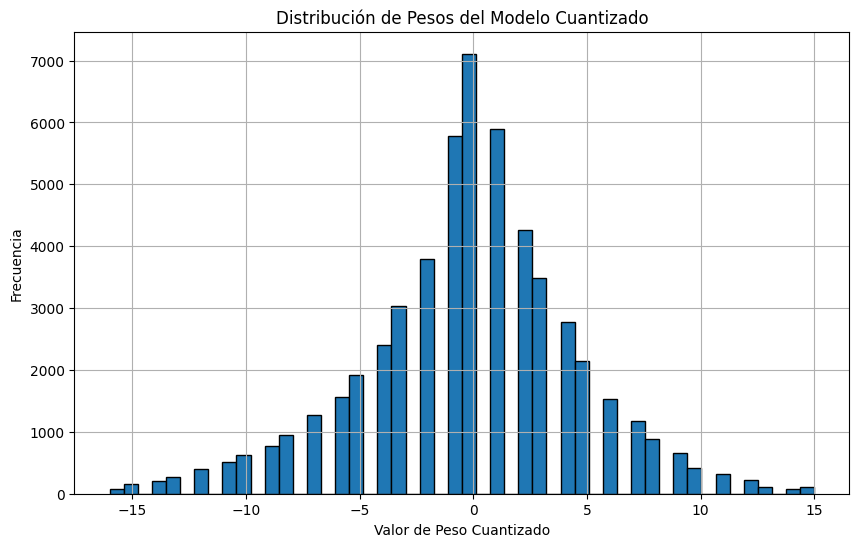

In [61]:
import torch
import matplotlib.pyplot as plt

def get_quantized_weights(model):
    weights = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.quantized.Linear) or isinstance(module, torch.nn.quantized.Conv2d):
            # Para capas cuantizadas, obtenemos los pesos directamente
            weight = module.weight()
            weights.extend(weight.int_repr().flatten().cpu().numpy())  # Convertimos a numpy
    return weights

# Asumiendo que 'quantized_model' es tu modelo cuantizado
quantized_weights = get_quantized_weights(model_int5)

# Graficar la distribución de los pesos cuantizados
plt.figure(figsize=(10, 6))
plt.hist(quantized_weights, bins=50, edgecolor='black')
plt.title('Distribución de Pesos del Modelo Cuantizado')
plt.xlabel('Valor de Peso Cuantizado')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


In [62]:
# Verificar los tipos de operadores en el modelo cuantizado
for layer in model_int5.modules():
    print(layer)


QATSimpleNN(
  (quant): Quantize(scale=tensor([0.0323]), zero_point=tensor([0]), dtype=torch.quint8)
  (fc1): QuantizedLinear(in_features=784, out_features=64, scale=0.8323286175727844, zero_point=19, qscheme=torch.per_channel_affine)
  (fc2): QuantizedLinear(in_features=64, out_features=64, scale=0.9763694405555725, zero_point=18, qscheme=torch.per_channel_affine)
  (fc3): QuantizedLinear(in_features=64, out_features=10, scale=1.799384593963623, zero_point=20, qscheme=torch.per_channel_affine)
  (dequant): DeQuantize()
)
Quantize(scale=tensor([0.0323]), zero_point=tensor([0]), dtype=torch.quint8)
QuantizedLinear(in_features=784, out_features=64, scale=0.8323286175727844, zero_point=19, qscheme=torch.per_channel_affine)
(tensor([[ 0.0309,  0.0309,  0.0309,  ..., -0.0309, -0.0309,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0380,  0.0000,  0.0000],
        [ 0.0171,  0.0057,  0.0057,  ..., -0.0028, -0.0114, -0.0114],
        ...,
        [ 0.0373, -0.0373,  0.0373,  ...,  0.0

In [63]:

# Guardar el modelo cuantizado
torch.save(model_int5, 'models/qat_mnist_model_5.pth')


In [64]:
quantized5bits_model_size = os.path.getsize('models/qat_mnist_model_5.pth')
print(f"Tamaño del modelo cuantizado: {quantized5bits_model_size / 1024:.2f} KB")

Tamaño del modelo cuantizado: 63.47 KB


# Grafics of Post Training Quantization

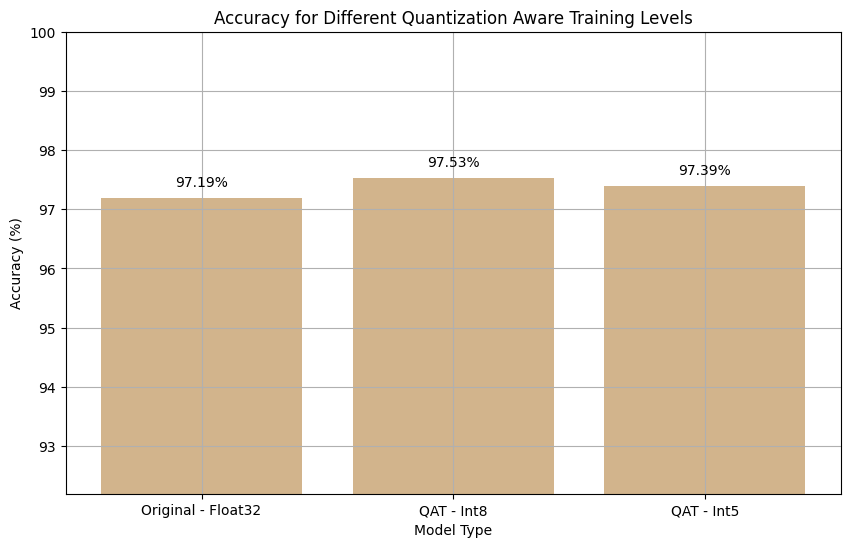

In [65]:
import matplotlib.pyplot as plt

# Etiquetas para cada modelo
labels = ['Original - Float32', 'QAT - Int8', 'QAT - Int5']

# Valores de precisión
accuracies = [acc_original_model, acc_qat_8bits, acc_qat_5bits]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color='tan')

# Agregar títulos y etiquetas
plt.title('Accuracy for Different Quantization Aware Training Levels')
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.2, f'{v:.2f}%', ha='center', fontsize=10)

# Mostrar la gráfica
plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.show()


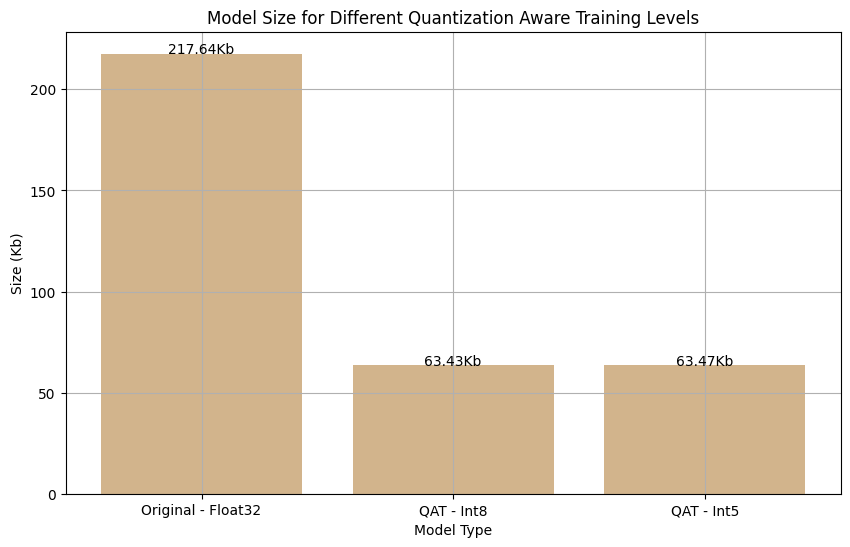

In [70]:
original_model_size = os.path.getsize('models/original_model.pth')/1024
quantized5bits_model_size = os.path.getsize('models/qat_mnist_model_5.pth') / 1024
quantized8bits_model_size = os.path.getsize('models/qat_mnist_model.pth') / 1024


import matplotlib.pyplot as plt

# Etiquetas para cada modelo
labels = ['Original - Float32', 'QAT - Int8', 'QAT - Int5']

# Valores de tamaño
sizes = [original_model_size, quantized8bits_model_size, quantized5bits_model_size]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color='tan')

# Agregar títulos y etiquetas
plt.title('Model Size for Different Quantization Aware Training Levels')
plt.xlabel('Model Type')
plt.ylabel('Size (Kb)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(sizes):
    plt.text(i, v + 0.2, f'{v:.2f}Kb', ha='center', fontsize=10)

# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.show()


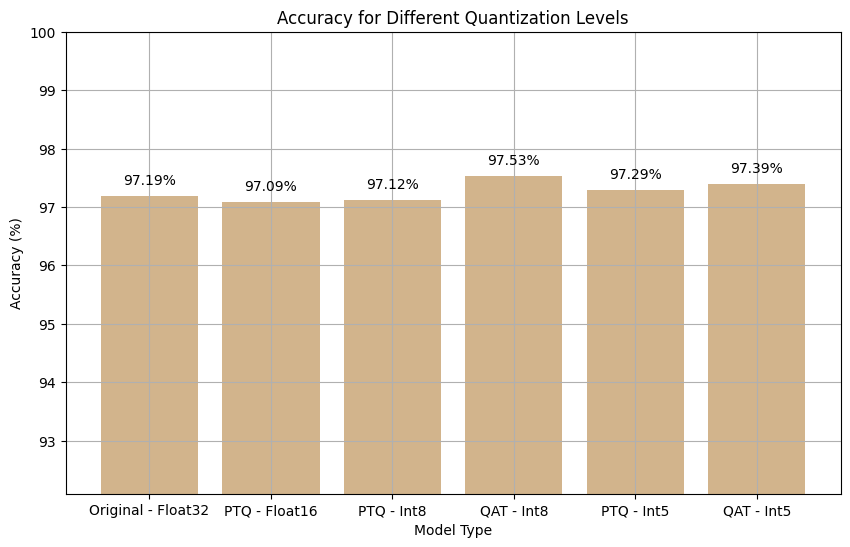

In [67]:
import matplotlib.pyplot as plt

# Etiquetas para cada modelo
labels = ['Original - Float32', 'PTQ - Float16', 'PTQ - Int8', 'QAT - Int8', 'PTQ - Int5', 'QAT - Int5']

# Valores de precisión
accuracies = [acc_original_model, acc_postTraining_16bit, acc_postTraining_8bit, acc_qat_8bits, acc_postTraining_5bit, acc_qat_5bits]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color='tan')

# Agregar títulos y etiquetas
plt.title('Accuracy for Different Quantization Levels')
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.2, f'{v:.2f}%', ha='center', fontsize=10)

# Mostrar la gráfica
plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.show()


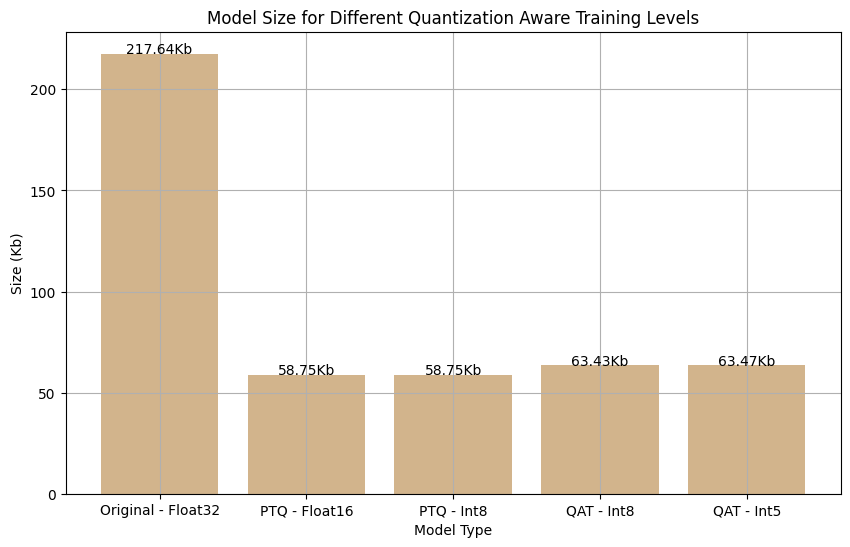

In [ ]:
original_model_size = os.path.getsize('models/original_model.pth')/1024
qat5bits_model_size = os.path.getsize('models/qat_mnist_model_5.pth') / 1024
qat8bits_model_size = os.path.getsize('models/qat_mnist_model.pth') / 1024
ptq5bits_model_size = os.path.getsize('models/model_quant_5bits_compressed.npz')/1024
ptq8bits_model_size = os.path.getsize('models/model_quant_int8.pth') / 1024
ptq16bits_model_size = os.path.getsize('models/model_quant_float16.pth') / 1024



import matplotlib.pyplot as plt

# Etiquetas para cada modelo
labels = ['Original - Float32', 'PTQ - Float16', 'PTQ - Int8', 'QAT - Int8', 'QAT - Int5']

# Valores de tamaño
sizes = [original_model_size, ptq16bits_model_size, ptq8bits_model_size, qat8bits_model_size, qat5bits_model_size]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color='tan')

# Agregar títulos y etiquetas
plt.title('Model Size for Different Quantization Aware Training Levels')
plt.xlabel('Model Type')
plt.ylabel('Size (Kb)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(sizes):
    plt.text(i, v + 0.2, f'{v:.2f}Kb', ha='center', fontsize=10)

# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.show()


In [69]:
import torch
import time
import numpy as np
from torchsummary import summary

original_model=SimpleNN()
original_model.load_state_dict(torch.load('models/original_model.pth'))
original_model.eval()

qat8bits_model=torch.load('models/qat_mnist_model.pth')
qat8bits_model.eval()

#qat5bits_model=SimpleNN()
qat5bits_model=torch.load('models/qat_mnist_model_5.pth')
qat5bits_model.eval()  

ptq5bits_model=SimpleNN()
ptq5bits_model = load_quantized_model(loaded_model, 'models/model_quant_5bits_compressed.npz')

ptq8bits_model=torch.load('models/model_quant_int8.pth')
ptq8bits_model.eval()

ptq16bits_model=torch.load('models/model_quant_int8.pth')
ptq16bits_model.eval()



/tmp/ipykernel_102520/483562506.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load('models/original_model.pth'))
/tmp/ipykernel_10

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [170]:
input_sample = torch.randn(1, 1, 28, 28)  


# Función para medir el tiempo de ejecución de la predicción
def measure_execution_time(model, input_sample):
    #model.eval()  # Cambiar el modelo a modo evaluación
    with torch.no_grad():
        start_time = time.time()
        model(input_sample)
        end_time = time.time()
    return (end_time - start_time)/1000

def get_model_parameters(model):
    total_params = 0
    trainable_params = 0
    
    for name, module in model.named_modules():
        # Si es una capa cuantizada (como Linear o Conv2d), accedemos a los pesos de forma diferente
        if isinstance(module, torch.nn.quantized.Linear) or isinstance(module, torch.nn.quantized.Conv2d):
            # Obtenemos los pesos de la capa cuantizada
            weight = module.weight()
            total_params += weight.numel()
            # En modelos cuantizados, los pesos no son entrenables en el sentido tradicional
        elif hasattr(module, 'weight') and module.weight is not None:
            # Para capas no cuantizadas, contamos los pesos normalmente
            total_params += module.weight.numel()
            if module.weight.requires_grad:
                trainable_params += module.weight.numel()
        
        # Contamos los parámetros del bias si están presentes
        if hasattr(module, 'bias'):
            # Si bias es una función (caso de capas cuantizadas), accedemos a ella correctamente
            bias = module.bias() if callable(module.bias) else module.bias
            if bias is not None:
                total_params += bias.numel()
                if bias.requires_grad:
                    trainable_params += bias.numel()

    return total_params, trainable_params

# Ejemplo de uso
total_params, trainable_params = get_model_parameters(qat5bits_model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 55050
Trainable parameters: 138


In [173]:
model_summaries = []


print('Original Model')
pytorch_total_params = sum(p.numel() for p in original_model.parameters())
print('Number of parameters',pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in original_model.parameters() if p.requires_grad)
print('Number of trainable parameters',pytorch_total_params)
execution_time=measure_execution_time(original_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['Original Model', pytorch_total_params, pytorch_trainable_params, execution_time])


print('QAT 8 bits Model')
total, trainable_params = get_model_parameters(qat8bits_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable_params}")
execution_time=measure_execution_time(qat8bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['QAT 8 bits Model', total, trainable_params, execution_time])


print('QAT 5 bits Model')
total, trainable_params = get_model_parameters(qat5bits_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable_params}")
execution_time=measure_execution_time(qat5bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['QAT 5 bits Model', total, trainable_params, execution_time])


print('PTQ 5 bits Model')
pytorch_total_params = sum(p.numel() for p in ptq5bits_model.parameters())
print('Number of parameters',pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in ptq5bits_model.parameters() if p.requires_grad)
print('Number of trainable parameters',pytorch_total_params)
execution_time=measure_execution_time(ptq5bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['PTQ 5 bits Model', pytorch_total_params, pytorch_trainable_params, execution_time])


print('PTQ 8 bits Model')
total, trainable_params = get_model_parameters(ptq8bits_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable_params}")
execution_time=measure_execution_time(ptq8bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['PTQ 8 bits Model', total, trainable_params, execution_time])


print('PTQ 16 bits Model')
total, trainable_params = get_model_parameters(ptq16bits_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable_params}")
execution_time=measure_execution_time(ptq16bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['PTQ 16 bits Model', total, trainable_params, execution_time])


headers = ['Model', 'Total Parameters', 'Trainable Parameters', 'Execution Time (miliseconds)']
print(tabulate(model_summaries, headers, tablefmt='grid'))



Original Model
Number of parameters 55050
Number of trainable parameters 55050
Time execution 1.360177993774414e-06 miliseconds


QAT 8 bits Model
Total parameters: 55050
Trainable parameters: 138
Time execution 2.9325485229492187e-07 miliseconds


QAT 5 bits Model
Total parameters: 55050
Trainable parameters: 138
Time execution 2.6226043701171877e-07 miliseconds


PTQ 5 bits Model
Number of parameters 55050
Number of trainable parameters 55050
Time execution 1.0657310485839844e-07 miliseconds


PTQ 8 bits Model
Total parameters: 55050
Trainable parameters: 138
Time execution 1.86920166015625e-07 miliseconds


PTQ 16 bits Model
Total parameters: 55050
Trainable parameters: 138
Time execution 1.7619132995605469e-07 miliseconds


+-------------------+--------------------+------------------------+----------------------------+
| Model             |   Total Parameters |   Trainable Parameters |   Execution Time (seconds) |
+===================+====================+========================+=